In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

### A/B test process
The A/B test process involves several key steps to ensure that the test is conducted effectively and that the results are reliable. Here's a detailed breakdown:

1. **Objective Definition**: Clearly define the goal of the A/B test. This could be to increase website conversion rates, improve email open rates, enhance user engagement, etc.

2. **Hypothesis Formation**: Based on the objective, form a hypothesis that predicts the outcome of the A/B test. For example, "Changing the call-to-action button from green to red will increase click-through rates."

3. **Identify Variables**: Determine the independent variable (the element you will change - e.g., button color) and the dependent variable (the metric you will measure - e.g., click-through rate).

4. **Create Variations**: Develop the two versions to be tested. Version A is usually the current version (control), and Version B is the new version with changes (treatment).

5. **Segmentation of Participants**: Decide how you will divide your audience into two or more groups. Ensure that the segmentation is random to avoid bias.

6. **Determine Sample Size**: Calculate the sample size needed for the test to be statistically significant. This depends on your expected effect size, desired power, and significance level.

7. **Run the Test**: Implement the A/B test by exposing the respective groups to the different versions and collecting data on their behavior.

8. **Analyze Results**: Use statistical methods to analyze the data and determine if there is a significant difference between the two groups. Commonly used statistical tests include t-tests, chi-square tests, and ANOVA.

9. **Make Decisions**: Based on the analysis, decide whether to adopt the new version, keep the old version, or run additional tests if the results are inconclusive.

10. **Report Findings**: Document the test process, analysis, and final decision. This is important for organizational learning and for informing future tests.

11. **Implementation**: If the new version is chosen, implement the changes for all users.

It's crucial to run A/B tests properly to avoid common pitfalls such as running the test for too short a time, testing too many variables at once, or making decisions based on non-significant results.

In [3]:
# Load the data from the CSV file
df_ab_test = pd.read_csv("./data/ab_test_click_data.csv")

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(df_ab_test.head())
print(df_ab_test.describe())
print(df_ab_test.groupby("group").sum("click"))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


A simple bar chart showing the total clicks versus no-clicks in each group can provide a clear visual comparison of user engagement.

group
con    10000
exp    10000
dtype: int64


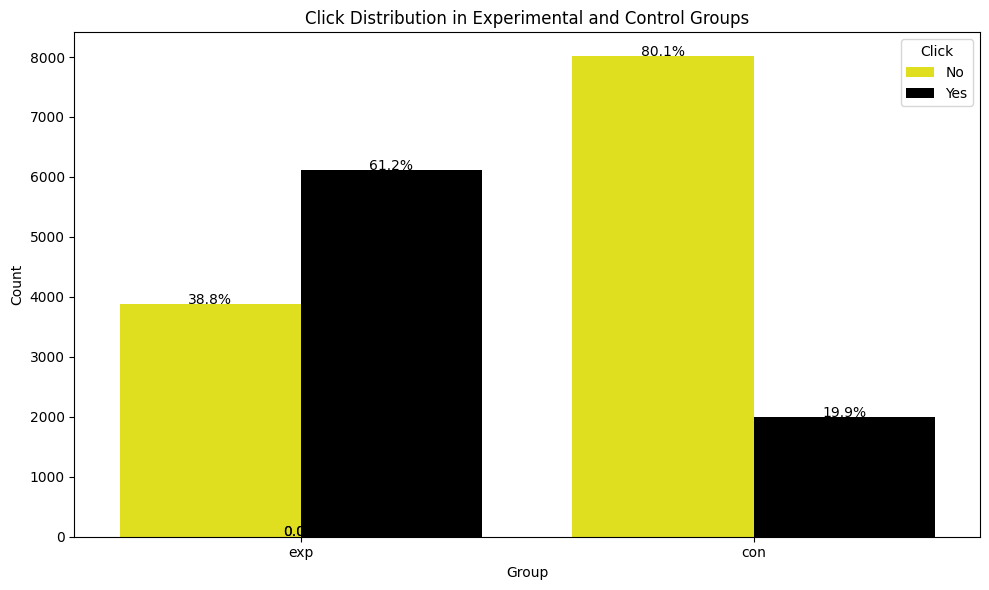

In [9]:
# Custom palette for yellow and black
palette = {0:"yellow", 1:"black"} # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="group",hue="click",data=df_ab_test,palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel("Group")
plt.ylabel("Count")
plt.legend(title="Click", labels=["No", "Yes"])

plt.title('Click Distribution in Experimental and Control Groups')

# Calculate the percentages and annotate the bars
group_counts = df_ab_test.groupby(["group"]).size()
print(group_counts)
group_click_counts = df_ab_test.groupby(["group","click"]).size().reset_index(name="count")

for p in ax.patches:
    height = p.get_height()
    # find the group and click type for the current bar
    group = "exp" if p.get_x() < 0.5 else "con"
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100* height / total
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            f"{percentage:.1f}%",
            ha="center",
            color="black",
            fontsize=10)
plt.tight_layout()
plt.show()

### Parameters of the Model from Power Analysis
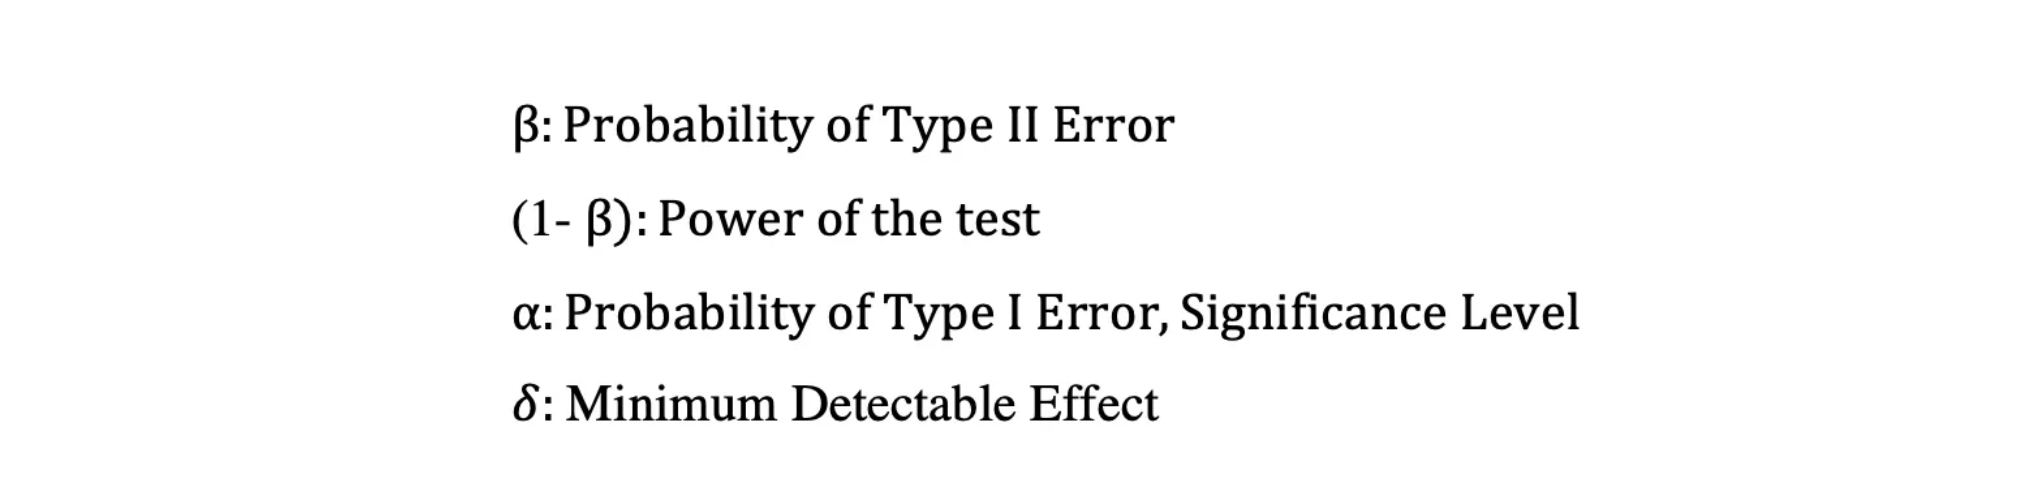

In [14]:
alpha = 0.05 # significance level
delta = 0.1 # minimum detectable effect

### Calculating total number of clicks per group by summing clicks

In [20]:
n_con = df_ab_test[df_ab_test["group"]=="con"].count()["user_id"]
n_exp = df_ab_test[df_ab_test["group"]=="exp"].count()["user_id"]

# calculating the total number of clicks per group by summing 1's
x_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
x_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# print this for visibility
print(df_ab_test.groupby("group")["click"].sum())
print("Number of user in control group: ", n_con)
print("Number of user in experimental group: ", n_exp)
print("Number of clicks in control group: ", x_con)
print("Number of clicks in experimental group: ", x_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of user in control group:  10000
Number of user in experimental group:  10000
Number of clicks in control group:  1989
Number of clicks in experimental group:  6116


### Calculating Pooled Estimates for Clicks per Group

In [11]:
# computing the estimate of click probability per group
p_con_hat = x_con / n_con
p_exp_hat = x_exp / n_exp
print("Click probability in control group: ", p_con_hat)
print("Click probability in experimental group: ", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (x_con + x_exp) / (n_con + n_exp)
print("Pooled click probability: ", p_pooled_hat)

Click probability in control group:  0.1989
Click probability in experimental group:  0.6116
Pooled click probability:  0.40525


### Calculating Pooled Variance

In [12]:
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1 - p_pooled_hat) * (1 / n_con + 1 / n_exp)
print("Pooled variance: ", pooled_variance)

Pooled variance:  4.82044875e-05


### Calculating Standard Error and Test Statistics

In [15]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error: ", SE)

# computing the test statistics of Z-test
test_stat = (p_con_hat - p_exp_hat) / SE
print("Test statistics for 2-sample z-test is: ", test_stat)

# critical value of the Z-test
z_crit = norm.ppf(1 - alpha/2)
print("Critical value of Z-test at alpha=0.05 is: ", z_crit)

Standard Error:  0.006942945160376826
Test statistics for 2-sample z-test is:  -59.44163326469381
Critical value of Z-test at alpha=0.05 is:  1.959963984540054


### Calculating p_values of the Z-test
- A low p-value (p ≤ 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
- A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [16]:
#calculating p value
p_value = 2 * norm.sf(abs(test_stat))

# function checking the statistical significance
def is_statistically_significant(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.
    
    Parameters:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float,optional): The significance level threshold used to determine statistical significance.default is 0.05.

    Retruns:
    - Prints the assessment of statistical significance.
    """
    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {(p_value)}")
    if p_value < alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance. This implies that the changes in the experimental group do not have a substantial effect compared to the control group.")
is_statistically_significant(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.


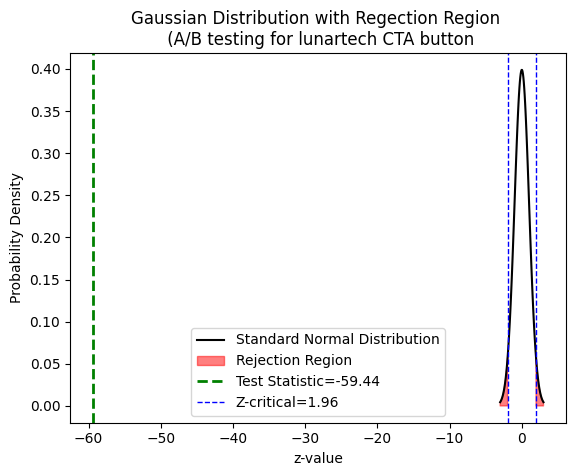

In [17]:
# Parameters for the standard normal distribution
mu = 0 # mean
sigma = 1 # standard deviation
x = np.linspace(mu-3*sigma,mu+3*sigma,100)
y = norm.pdf(x, mu, sigma)

# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution', color='black')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > z_crit)|(x < -z_crit), color='red', alpha=0.5, label='Rejection Region')

# Adding Test Statistic
plt.axvline(test_stat, color='green', linestyle='dashed',linewidth=2, label=f'Test Statistic={test_stat:.2f}')
# Adding Z-critical values
plt.axvline(z_crit, color='blue', linestyle='dashed',linewidth=1, label=f'Z-critical={z_crit:.2f}')
plt.axvline(-z_crit, color='blue', linestyle='dashed',linewidth=1)

# adding labels and title
plt.xlabel("z-value")
plt.ylabel("Probability Density")
plt.title("Gaussian Distribution with Regection Region \n (A/B testing for lunartech CTA button")
plt.legend()
plt.show()

### Calculating Confidence Interval of the test

In [18]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI = [round((p_exp_hat-p_con_hat)-SE*z_crit,3),# Lower bound of the CI, rounded to 3 decimal places
      round((p_exp_hat-p_con_hat)+SE*z_crit,3)] # Upper bound of the CI, rounded to 3 decimal places

# print the calculated confidence interval
print("confidence interval of the 2 sample Z-test is: ", CI)
# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group proportions is likely to lie with a certain level of confidence (e.g., 95%).


confidence interval of the 2 sample Z-test is:  [np.float64(0.399), np.float64(0.426)]


### Testing for Practical Significance in A/B Testing

In [19]:
def is_practivally_significant(delta,CI_95):
    """
    We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE) parameter from the Power Analysis.

    Parameters:
    - delta (float): The minimum detectable effect (MDE) used to determine practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    """
    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]
    # Check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI >= delta:
        print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significant.")
    else:
        print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")

is_practivally_significant(delta,CI)
print("Lower bound of 95% confidence interval is: ", CI[0])

We have practical significance! 
With MDE of 0.1, The difference between Control and Experimental group is practically significant.
Lower bound of 95% confidence interval is:  0.399
